# Générateur de Noms de Domaine avec LLM
## Expérimentations et Évaluations Systématiques

Ce notebook présente le développement itératif d'un système de génération de noms de domaine utilisant des modèles de langage, avec un focus sur l'évaluation automatisée et la découverte de cas limites.

## 1. Configuration et Imports

In [1]:
import sys
import os
sys.path.append("..")
import numpy as np
import pandas as pd
import seaborn as sns
import collections
from datetime import datetime
import matplotlib.pyplot as plt

# Import des modules du projet
from src.creation_dataset import CreationDataset
from src.generateur_nom_domaine import GenerateurNomsDomaine
from src.utils import charger_json, sauvegarder_json, generer_timestamp
from src.evaluateur_llm import EvaluateurLLM


print(f"Date de l'expérience: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Date de l'expérience: 2025-08-03 20:32:15


## 2. Création du Dataset Synthétique

Nous commençons par créer un dataset synthétique diversifié pour l'évaluation.

In [2]:
# Initialiser le créateur de dataset
creation_dataset = CreationDataset()

# Créer le dataset complet
print("Création du dataset synthétique...")
chemin_dataset = creation_dataset.sauvegarder_dataset("dataset_experimental.json")

# Charger et analyser le dataset créé
dataset_complet = charger_json(chemin_dataset)

print(f"Dataset créé avec succès:")
print(f"   - Exemples d'entraînement: {len(dataset_complet['entrainement'])}")
print(f"   - Cas limites: {len(dataset_complet['cas_limites'])}")

# Visualisation de la distribution des types de business
descriptions = [ex['description_business'] for ex in dataset_complet['entrainement']]
print(f"\nExemples de descriptions générées:")
for i, desc in enumerate(descriptions[:5]):
    print(f"   {i+1}. {desc}")

INFO:src.utils:Génération d'un dataset de 1000 exemples...
INFO:src.utils:Généré 100/1000 exemples
INFO:src.utils:Généré 200/1000 exemples
INFO:src.utils:Généré 300/1000 exemples
INFO:src.utils:Généré 400/1000 exemples
INFO:src.utils:Généré 500/1000 exemples
INFO:src.utils:Généré 600/1000 exemples
INFO:src.utils:Généré 700/1000 exemples
INFO:src.utils:Généré 800/1000 exemples
INFO:src.utils:Généré 900/1000 exemples
INFO:src.utils:Généré 1000/1000 exemples
INFO:src.utils:Données sauvegardées dans ../data/dataset_experimental.json
INFO:src.utils:Dataset complet sauvegardé: ../data/dataset_experimental.json
INFO:src.utils:Données chargées depuis ../data/dataset_experimental.json


Création du dataset synthétique...
Dataset créé avec succès:
   - Exemples d'entraînement: 1000
   - Cas limites: 14

Exemples de descriptions générées:
   1. développement mobile dans Silicon Valley
   2. distribution livres dans marché local
   3. Service de vêtements via distribution premium
   4. Nouveau entreprise tech IA abordable à Paris
   5. Nouveau brasserie végétarien premium à centre-ville


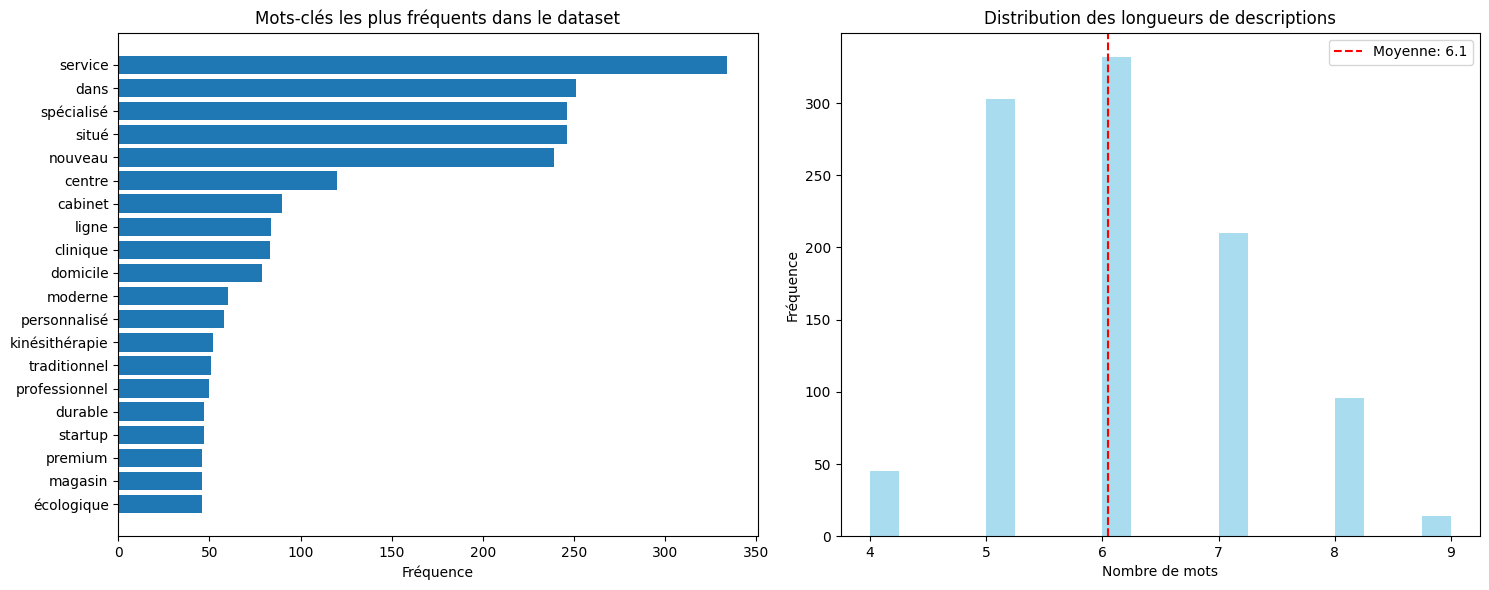

Statistiques du dataset:
   - Longueur moyenne des descriptions: 6.1 mots
   - Longueur médiane: 6.0 mots
   - Vocabulaire unique: 90 mots


In [3]:
# Analyser les mots-clés les plus fréquents
tous_mots = []
for desc in descriptions:
    mots = desc.lower().split()
    tous_mots.extend([mot for mot in mots if len(mot) > 3])

mots_frequents = collections.Counter(tous_mots).most_common(20)

# Créer une visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des mots les plus fréquents
mots, freq = zip(*mots_frequents)
ax1.barh(range(len(mots)), freq)
ax1.set_yticks(range(len(mots)))
ax1.set_yticklabels(mots)
ax1.set_xlabel('Fréquence')
ax1.set_title('Mots-clés les plus fréquents dans le dataset')
ax1.invert_yaxis()

# Distribution des longueurs de descriptions
longueurs = [len(desc.split()) for desc in descriptions]
ax2.hist(longueurs, bins=20, alpha=0.7, color='skyblue')
ax2.set_xlabel('Nombre de mots')
ax2.set_ylabel('Fréquence')
ax2.set_title('Distribution des longueurs de descriptions')
ax2.axvline(np.mean(longueurs), color='red', linestyle='--', label=f'Moyenne: {np.mean(longueurs):.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Statistiques du dataset:")
print(f"   - Longueur moyenne des descriptions: {np.mean(longueurs):.1f} mots")
print(f"   - Longueur médiane: {np.median(longueurs):.1f} mots")
print(f"   - Vocabulaire unique: {len(set(tous_mots))} mots")

## 3. Initialisation du Modèle Générateur

Configuration et test initial du générateur basé sur Llama3.1

In [4]:
# Initialiser le générateur de base
print("Initialisation du générateur de noms de domaine...")
try:
    generateur = GenerateurNomsDomaine(model="llama3.1", garde_fous=True, garde_fous_use_llm=False)
    info_modele = generateur.obtenir_info_modele()
    
    print("Générateur initialisé avec succès")
    print(f"   - Modèle: {info_modele['nom_modele']}")
    print(f"   - URL de base: {info_modele['base_url']}")
    print(f"   - Garde-fous activés: {info_modele['garde_fous_actifs']}")
    print(f"   - Styles disponibles: {', '.join(info_modele['styles_disponibles'])}")
    
except Exception as e:
    print(f"Erreur lors de l'initialisation: {e}")
    print("Vérifiez qu'Ollama est en cours d'exécution et que le modèle llama3.1 est téléchargé")
    print("   Commandes à exécuter:")
    print("   - ollama serve")
    print("   - ollama pull llama3.1")

INFO:src.utils:Modèle llama3.1 initialisé avec succès


Initialisation du générateur de noms de domaine...
Générateur initialisé avec succès
   - Modèle: llama3.1
   - URL de base: http://localhost:11434
   - Garde-fous activés: True
   - Styles disponibles: professionnel, creatif, moderne, classique, court


In [5]:
# Test initial avec des exemples variés
descriptions_test = [
    "restaurant italien familial avec terrasse au centre-ville",
    "startup de développement d'applications mobiles innovantes",
    "cabinet de conseil en marketing digital pour PME",
    "boutique de vêtements bio et éthiques en ligne",
    "école de formation en intelligence artificielle"
]

print("Tests initiaux du générateur ...\n")

resultats = []

for i, description in enumerate(descriptions_test, 1):
    print(f"Test {i}/{len(descriptions_test)}: {description}")

    try:
        resultat = generateur.generer_suggestions(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        
        if resultat["status"] == "success":
            print("Suggestions générées:")
            for suggestion in resultat["suggestions"]:
                print(f"   - {suggestion['domaine']} (confiance: {suggestion['confidence']})")
            print(f"   Durée: {resultat['metadata']['duree_generation_sec']}s\n")
            
            resultats.append({
                "description": description,
                "resultats": resultat
            })
        else:
            print(f"Échec: {resultat.get('message', 'Erreur inconnue')}\n")
            
    except Exception as e:
        print(f"Erreur: {e}\n")

print(f"Tests baseline terminés: {len(resultats)}/{len(descriptions_test)} réussis")

INFO:src.utils:Génération de 3 | suggestions pour: restaurant italien familial avec terrasse au centr...


Tests initiaux du générateur ...

Test 1/5: restaurant italien familial avec terrasse au centre-ville


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: startup de développement d'applications mobiles in...


Suggestions générées:
   - bellavista.com (confiance: 0.9)
   - maisonditalie.fr (confiance: 0.9)
   - terrarossa.org (confiance: 0.8)
   Durée: 57.9s

Test 2/5: startup de développement d'applications mobiles innovantes


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: cabinet de conseil en marketing digital pour PME...


Suggestions générées:
   - appligenius.com (confiance: 0.9)
   - appinova.fr (confiance: 0.9)
   - mobilium.net (confiance: 0.8)
   Durée: 42.69s

Test 3/5: cabinet de conseil en marketing digital pour PME


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: boutique de vêtements bio et éthiques en ligne...


Suggestions générées:
   - luminemarketing.org (confiance: 0.8)
   - digitiaconsulting.com (confiance: 0.7)
   Durée: 40.55s

Test 4/5: boutique de vêtements bio et éthiques en ligne


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 1 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: école de formation en intelligence artificielle...


Suggestions générées:
   - vestiabio.fr (confiance: 0.9)
   Durée: 37.88s

Test 5/5: école de formation en intelligence artificielle


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées


Suggestions générées:
   - cerebroai.com (confiance: 0.9)
   - artifa.net (confiance: 0.8)
   - iapro.fr (confiance: 0.8)
   Durée: 43.37s

Tests baseline terminés: 5/5 réussis


## 4. Implémentation du Système d'Évaluation LLM-as-a-Judge

Création d'un évaluateur automatique pour mesurer la qualité des suggestions de noms de domaine.

In [6]:
# Initialiser l'évaluateur LLM
print("⚖️ Initialisation du système d'évaluation LLM-as-a-Judge...")

try:
    evaluateur = EvaluateurLLM(type_evaluateur="openai", model="gpt-4o-mini") # Pour OpenAI
    # evaluateur = EvaluateurLLM(type_evaluateur="ollama", model="llama3.1") # Pour Ollama ==> llma3.1
    # evaluateur = EvaluateurLLM(type_evaluateur="ollama", model="deepseek-r1") # Pour Ollama ==> deepseek-r1
    print("Évaluateur initialisé avec succès")
    
    # Afficher les critères d'évaluation
    criteres = evaluateur.obtenir_criteres_evaluation()
    print("\nCritères d'évaluation:")
    for critere, description in criteres.items():
        print(f"   - {critere.capitalize()}: {description}")
        
except Exception as e:
    print(f"Erreur lors de l'initialisation de l'évaluateur: {e}")
    print("L'évaluateur utilisera le même modèle que le générateur")

⚖️ Initialisation du système d'évaluation LLM-as-a-Judge...


INFO:src.utils:Évaluateur OpenAI initialisé: gpt-4o-mini


Évaluateur initialisé avec succès

Critères d'évaluation:
   - Pertinence: Adéquation du nom de domaine à l'activité décrite
   - Creativite: Originalité et mémorabilité du nom
   - Memorabilite: Facilité de mémorisation et de pronunciation
   - Disponibilite_estimee: Probabilité que le domaine soit disponible
   - Professionnalisme: Aspect professionnel et sérieux du nom


In [7]:
# Test du système d'évaluation avec les résultats
print("Évaluation des résultats...\n")

evaluations_baseline = []

for i, resultat_test in enumerate(resultats, 1):
    description = resultat_test["description"]
    domaines = [s["domaine"] for s in resultat_test["resultats"]["suggestions"]]
    
    print(f"Évaluation {i}/{len(resultats)}: {description}")
    print(f"   Domaines proposés: {', '.join(domaines)}")
    
    try:
        evaluation = evaluateur.evaluer_suggestions(
            description_business=description,
            suggestions_domaines=domaines
        )
        
        if evaluation["status"] == "success":
            scores = evaluation["evaluations"]
            score_moyen = np.mean([s["score_total"] for s in scores])
            
            print(f"   Score moyen: {score_moyen:.2f}/10")
            
            # Afficher le détail du meilleur domaine
            meilleur = max(scores, key=lambda x: x["score_total"])
            print(f"   Meilleur: {meilleur['domaine']} ({meilleur['score_total']:.1f}/10)")
            print(f"   Pertinence: {meilleur['pertinence']:.1f}, Créativité: {meilleur['creativite']:.1f}")
            
            evaluations_baseline.append({
                "description": description,
                "domaines": domaines,
                "evaluations": evaluation
            })
        else:
            print(f"  Échec de l'évaluation: {evaluation.get('message', 'Erreur inconnue')}")

    except Exception as e:
        print(f"  Erreur: {e}")

    print()

print(f"Évaluations terminées: {len(evaluations_baseline)} complétées")

Évaluation des résultats...

Évaluation 1/5: restaurant italien familial avec terrasse au centre-ville
   Domaines proposés: bellavista.com, maisonditalie.fr, terrarossa.org


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.30/10


   Score moyen: 6.30/10
   Meilleur: maisonditalie.fr (6.9/10)
   Pertinence: 8.0, Créativité: 6.5

Évaluation 2/5: startup de développement d'applications mobiles innovantes
   Domaines proposés: appligenius.com, appinova.fr, mobilium.net


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.07/10


   Score moyen: 7.07/10
   Meilleur: appinova.fr (7.3/10)
   Pertinence: 8.0, Créativité: 7.0

Évaluation 3/5: cabinet de conseil en marketing digital pour PME
   Domaines proposés: luminemarketing.org, digitiaconsulting.com


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 6.65/10


   Score moyen: 6.65/10
   Meilleur: luminemarketing.org (7.0/10)
   Pertinence: 8.0, Créativité: 7.0

Évaluation 4/5: boutique de vêtements bio et éthiques en ligne
   Domaines proposés: vestiabio.fr


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.40/10


   Score moyen: 7.40/10
   Meilleur: vestiabio.fr (7.4/10)
   Pertinence: 8.5, Créativité: 7.0

Évaluation 5/5: école de formation en intelligence artificielle
   Domaines proposés: cerebroai.com, artifa.net, iapro.fr


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:src.utils:Évaluation terminée: score moyen 7.23/10


   Score moyen: 7.23/10
   Meilleur: iapro.fr (7.7/10)
   Pertinence: 9.0, Créativité: 6.0

Évaluations terminées: 5 complétées


Statistiques des évaluations baseline:
       score_total  pertinence  creativite  memorabilite  disponibilite
count    12.000000   12.000000   12.000000     12.000000      12.000000
mean      6.875000    7.625000    6.958333      7.333333       5.125000
std       0.559423    1.316417    0.721688      0.887625       1.720531
min       5.600000    4.000000    6.000000      5.500000       2.000000
25%       6.700000    7.750000    6.375000      7.000000       3.875000
50%       6.950000    8.000000    7.000000      7.500000       5.250000
75%       7.150000    8.125000    7.500000      8.000000       6.250000
max       7.700000    9.000000    8.000000      8.500000       7.500000


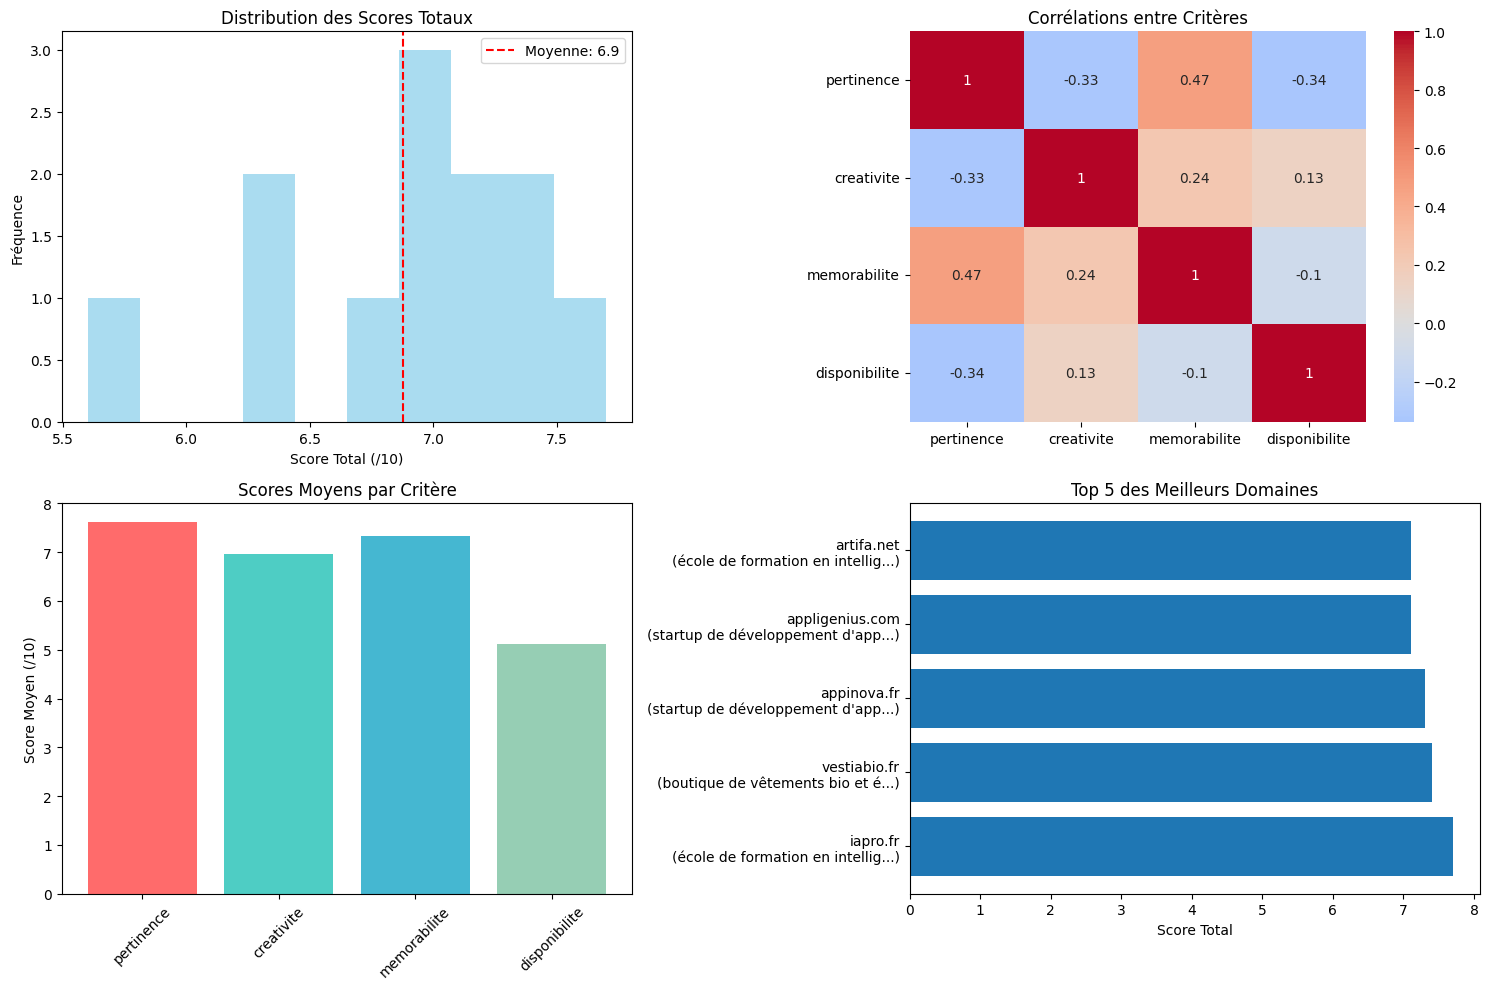

INFO:src.utils:Données sauvegardées dans ../data/evaluations/resultats_baseline.json



Analyse des performances baseline:
   - Score total moyen: 6.88/10
   - Critère le plus faible: disponibilite (5.12/10)
   - Critère le plus fort: pertinence (7.62/10)

Résultats baseline sauvegardés dans data/evaluations/resultats_baseline.json


In [9]:
# Analyse des résultats d'évaluation baseline
if evaluations_baseline:
    # Extraire tous les scores
    tous_scores = []
    for eval_result in evaluations_baseline:
        for eval_domaine in eval_result["evaluations"]["evaluations"]:
            tous_scores.append({
                "domaine": eval_domaine["domaine"],
                "description": eval_result["description"][:30] + "...",
                "score_total": eval_domaine["score_total"],
                "pertinence": eval_domaine["pertinence"],
                "creativite": eval_domaine["creativite"],
                "memorabilite": eval_domaine["memorabilite"],
                "disponibilite": eval_domaine["disponibilite_estimee"]
            })
    
    # Créer un DataFrame pour l'analyse
    df_scores = pd.DataFrame(tous_scores)
    
    print("Statistiques des évaluations baseline:")
    print(df_scores[['score_total', 'pertinence', 'creativite', 'memorabilite', 'disponibilite']].describe())
    
    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution des scores totaux
    axes[0,0].hist(df_scores['score_total'], bins=10, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution des Scores Totaux')
    axes[0,0].set_xlabel('Score Total (/10)')
    axes[0,0].set_ylabel('Fréquence')
    axes[0,0].axvline(df_scores['score_total'].mean(), color='red', linestyle='--', 
                     label=f'Moyenne: {df_scores["score_total"].mean():.1f}')
    axes[0,0].legend()
    
    # Corrélation entre critères
    correlation_matrix = df_scores[['pertinence', 'creativite', 'memorabilite', 'disponibilite']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
    axes[0,1].set_title('Corrélations entre Critères')
    
    # Scores par critère
    criteres = ['pertinence', 'creativite', 'memorabilite', 'disponibilite']
    moyennes_criteres = [df_scores[critere].mean() for critere in criteres]
    axes[1,0].bar(criteres, moyennes_criteres, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[1,0].set_title('Scores Moyens par Critère')
    axes[1,0].set_ylabel('Score Moyen (/10)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Top 5 des meilleurs domaines
    top_domaines = df_scores.nlargest(5, 'score_total')
    axes[1,1].barh(range(len(top_domaines)), top_domaines['score_total'])
    axes[1,1].set_yticks(range(len(top_domaines)))
    axes[1,1].set_yticklabels([f"{row['domaine']}\n({row['description']})" for _, row in top_domaines.iterrows()])
    axes[1,1].set_title('Top 5 des Meilleurs Domaines')
    axes[1,1].set_xlabel('Score Total')
    
    plt.tight_layout()
    plt.show()
    
    # Identifier les points faibles
    print("\nAnalyse des performances baseline:")
    print(f"   - Score total moyen: {df_scores['score_total'].mean():.2f}/10")
    print(f"   - Critère le plus faible: {criteres[np.argmin(moyennes_criteres)]} ({min(moyennes_criteres):.2f}/10)")
    print(f"   - Critère le plus fort: {criteres[np.argmax(moyennes_criteres)]} ({max(moyennes_criteres):.2f}/10)")
    
    # Sauvegarder les résultats baseline
    sauvegarder_json({
        "timestamp": generer_timestamp(),
        "version": "baseline",
        "evaluations": evaluations_baseline,
        "statistiques": {
            "score_moyen": float(df_scores['score_total'].mean()),
            "score_median": float(df_scores['score_total'].median()),
            "nombre_evaluations": len(df_scores)
        }
    }, "../data/evaluations/resultats_baseline.json")
    
    print("\nRésultats baseline sauvegardés dans data/evaluations/resultats_baseline.json")
    
else:
    print("Aucune évaluation baseline disponible pour l'analyse")